In [1]:
import numpy as np
import sys, os, pickle, h5py, time

from iminuit import Minuit
from scipy import stats, optimize, ndimage, signal

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from IPython.display import clear_output

## Load the Digitized Data and Plot to Recreate Fig 4

In [3]:
data_archive = h5py.File('./Data_30keV.h5', 'r')

emins, emaxs = np.array(data_archive['BinEdges'])
flux_obs = np.array(data_archive['Flux'])
flux_err = np.array(data_archive['FluxError'])

ens_bkg, flux_bkg = np.array(data_archive['Background'])
ens_ABC, flux_ABC = np.array(data_archive['ABC_Model'])
ens_Prim, flux_Prim = np.array(data_archive['Primakoff'])
ens_57Fe, flux_57Fe = np.array(data_archive['57Fe'])

data_archive.close()

ens_flux = (emins + emaxs)/2
binsize = emaxs - emins

## Perform the Shifted Analysis and Do Fake Data Tests

In [5]:
def rebin(e, spectrum, E_Shift = 0):
    '''
    This method takes a spectrum specified by energies `e` [keV] and
    a spectrum `spectrum` [counts / (t * year * keV)] and rebins it to the energy resolution
    of the data.
    
    Optional argument `E_Shift` [keV] shifts the interpolated output by the specified amount
    ''' 
    
    interp_energies = np.linspace(e[0], e[-1], int(1e5))
    interp_spectrum = np.interp(interp_energies, e, spectrum)
    
    interp_energies += E_Shift
    
    binned_spectrum = np.zeros_like(emins)
    for i in range(len(binned_spectrum)):
        
        min_index = np.searchsorted(interp_energies, emins[i])
        max_index = np.searchsorted(interp_energies, emaxs[i])
        
        binned_spectrum[i] = np.trapz(interp_spectrum[min_index:max_index], interp_energies[min_index:max_index])
    return np.nan_to_num(binned_spectrum) / binsize


# Make the rebinned background spectrum
bkg_spectrum = rebin(ens_bkg, flux_bkg)
bkg_spectrum[-1] = bkg_spectrum[-2] # Manually correct the last data point

In [49]:
def ChiSq(data, errors, E_Shift, E_Min = 1, E_Max = 7, mask = False):
    '''
    This method components the improvement of the chi^2 statistic from the inclusion of an
    ABC spectrum shifted by `E_Shift` [keV] when fitting to data `data` with error `errors`.
    The background amplitude is not allowed to float.
    
    The optional arguments `E_Min` and `E_Max` [keV] specify lower and upper energy bounds 
    for the range over which we perform the fit. These bounds are shifted by `E_Shift`. By
    default, the window is 6 keV wide as in [2006.09721]. The mask argument [b] allows masking
    of the 4\sigma underfluctuation at 16 keV.
    
    Return the best fit signal amplitude, the 1\sigma and 2\sigma upper limits on the 
    signal amplitude, and the change in chi^2 statistic.
    '''
    
    abc_spectrum = rebin(ens_ABC, flux_ABC, E_Shift = E_Shift)
    
    locs = np.where(np.logical_and(emins >= E_Min + E_Shift, emaxs < E_Max + E_Shift))[0]
    if mask:
        locs = np.setdiff1d(locs, 16)
    
    obj = lambda A: np.sum(((data - A*abc_spectrum - bkg_spectrum)**2 / errors**2)[locs])
    NullChiSq = obj(0)
    
    m = Minuit(obj, A = 0, limit_A = [None, None], error_A = .1,errordef = 1)
    m.migrad()
    
    fit = m.values['A']
    SignalChiSq = m.fval

    m.minos('A', sigma = 1)
    one_sig_up =  m.values['A'] + m.merrors[('A', 1.0)]
    
    m.minos('A', sigma = 2)
    two_sig_up =m.values['A'] + m.merrors[('A', 1.0)]
    return fit, one_sig_up, two_sig_up, NullChiSq-SignalChiSq
    
    

In [50]:
E_Shifts = np.linspace(0, 23, 46)
Fit_Results = np.zeros((len(E_Shifts), 4))
Mask_Fit_Results = np.zeros((len(E_Shifts), 4))

for i in range(len(E_Shifts)):
    Fit_Results[i] = ChiSq(flux_obs, flux_err, E_Shifts[i])
    Mask_Fit_Results[i] = ChiSq(flux_obs, flux_err, E_Shifts[i], mask = True)
    
    
best_fit_index = np.argmax(Fit_Results[:, 3])
best_fit_template = Fit_Results[best_fit_index, 0] * rebin(ens_ABC, flux_ABC, E_Shift = E_Shifts[best_fit_index])+bkg_spectrum

In [14]:
mc_template = Fit_Results[0, 0] * rebin(ens_ABC, flux_ABC, E_Shift = 0)
mc_template += bkg_spectrum

mc_data = stats.norm.rvs(loc = mc_template, scale = flux_err, size = (5000, len(mc_template)))


MC_Fit_Results = np.zeros((mc_data.shape[0], len(E_Shifts), 4))

for i in range(MC_Fit_Results.shape[0]):
    for j in range(MC_Fit_Results.shape[1]):
        MC_Fit_Results[i, j] = ChiSq(mc_data[i], flux_err, E_Shifts[j])
    print(i)
clear_output()

# Plot the Various Results

In [ ]:

handles,labels = ax1.get_legend_handles_labels()
handles1 = [handles[0], handles[1], (m3 ,m4), handles[2]]
labels1 = [r'$95\%$ Upper Limit - This Work', 
           r'Expected Limit',
           r'$1/2\sigma$ Containment',
           r'CAST Exclusion']

axbox = ax1.get_position()
x_value= -0.1
y_value= .65

legend1 = plt.legend(handles1,labels1,loc = (axbox.x0 + x_value, axbox.y0 + y_value),
                     fancybox=True,facecolor='white',frameon=True, edgecolor = 'black', ncol = 2)



In [ ]:
# Adding the Legend
msize=30
m3, = plt.plot([], [], c='chartreuse' , marker='s', markersize=msize,
              fillstyle='left', linestyle='none',alpha=1.0)
m4, = plt.plot([], [], c='gold' , marker='s', markersize=msize,
              fillstyle='right', linestyle='none',alpha=1.0)

handles,labels = ax1.get_legend_handles_labels()
handles1 = [handles[0], handles[1], (m3 ,m4), handles[2]]
labels1 = [r'$95\%$ Upper Limit - This Work', 
           r'Expected Limit',
           r'$1/2\sigma$ Containment',
           r'CAST Exclusion']

axbox = ax1.get_position()
x_value= -0.1
y_value= .65

legend1 = plt.legend(handles1,labels1,loc = (axbox.x0 + x_value, axbox.y0 + y_value),
                     fancybox=True,facecolor='white',frameon=True, edgecolor = 'black', ncol = 2)

plt.gca().add_artist(legend1)


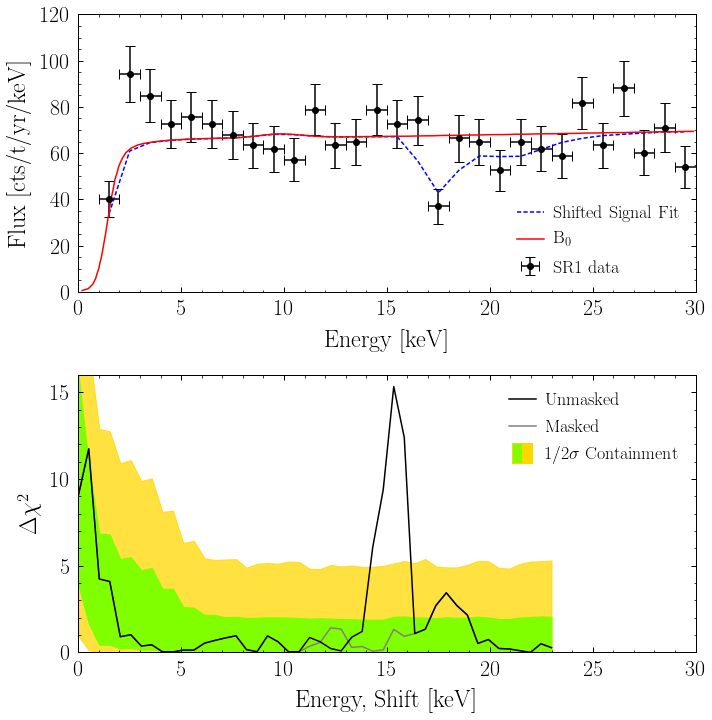

In [71]:
fig, axs = plt.subplots(nrows = 2)



axs[0].plot(ens_flux, best_fit_template, c='blue', ls = '--', label = 'Shifted Signal Fit')
axs[0].errorbar(ens_flux,flux_obs,xerr=binsize/2.,yerr=flux_err,fmt='o',color='k',capsize=5,label='SR1 data')
axs[0].plot(ens_bkg,flux_bkg,color='r',label='B$_0$')
axs[0].set_xlabel('Energy [keV]')
axs[0].set_ylabel('Flux [cts/t/yr/keV]')
axs[0].set_xlim(0,30)
axs[0].set_ylim(0,120)
axs[0].legend(loc='lower right',frameon=False, fontsize = 18)




axs[1].plot(E_Shifts, Fit_Results[:, 3], c = 'black', zorder = 11, label = 'Unmasked')
axs[1].plot(E_Shifts, Mask_Fit_Results[:, 3], c = 'grey', zorder = 10, label = 'Masked')


#plt.plot(E_Shifts, np.median(MC_Fit_Results[:, :, 3], axis = 0), '-s', c = 'black')
axs[1].fill_between(E_Shifts, np.quantile(MC_Fit_Results[:, :, 3], .025, axis = 0),
                 np.quantile(MC_Fit_Results[:, :, 3], .975, axis = 0), color = 'gold', alpha = .75)
axs[1].fill_between(E_Shifts, np.quantile(MC_Fit_Results[:, :, 3], .16, axis = 0),
                 np.quantile(MC_Fit_Results[:, :, 3], .84, axis = 0), color = 'chartreuse', alpha = 1.)


axs[1].set_ylim(0, 16)
axs[1].set_xlim(0, 30)
axs[1].set_xlabel('Energy, Shift [keV]')
axs[1].set_ylabel(r'$\Delta \chi^2$')
axs[1].legend()



msize=20
m3, = plt.plot([], [], c='chartreuse' , marker='s', markersize=msize,
              fillstyle='left', linestyle='none',alpha=1.0)
m4, = plt.plot([], [], c='gold' , marker='s', markersize=msize,
              fillstyle='right', linestyle='none',alpha=1.0)

handles,labels = axs[1].get_legend_handles_labels()
handles1 = [handles[0], handles[1], (m3 ,m4)]
labels1 = [r'Unmasked', r'Masked', r'$1/2\sigma$ Containment']

axbox = axs[1].get_position()
x_value= -0.1
y_value= .65

legend1 = axs[1].legend(handles1,labels1, frameon=False, fontsize = 18)

plt.tight_layout()
plt.subplots_adjust(hspace = .3)
plt.savefig('./Xenon30.pdf')
plt.show()

# Correct the Survival Function with a Nuisance Parameter

In [111]:
def Calc_New_TS(TS, Fit, sigma_sys):
    TS_New = TS * Fit**2 / (Fit**2 + TS * sigma_sys**2)
    return TS_New


def Tuning_Objective(TS, Fit, sigma_sys):
    target = int(np.ceil(stats.chi2.cdf(1, df = 1)*len(E_Shifts)))
    
    New_TS = Calc_New_TS(TS,Fit, sigma_sys)
    return np.sum(New_TS <= 1) - target
    
systematic = optimize.brentq(lambda x: Tuning_Objective(Fit_Results[:, 3], Fit_Results[:, 0], x), 0, 10)

In [115]:
Unmasked_TS_Corrected = Calc_New_TS(Fit_Results[:, 3], Fit_Results[:, 0], unmasked_systematic)
Masked_TS = Mask_Fit_Results[:, 3] # Masked TS distribution does not require 

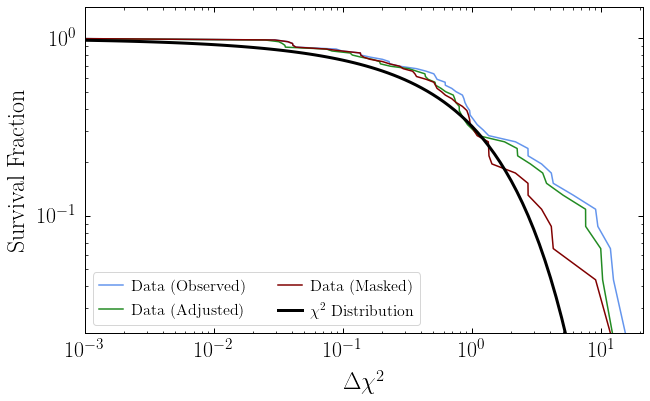

In [138]:
# Figure size
mpl.rcParams['figure.figsize'] = 10, 6

plt.plot(np.sort(Fit_Results[:, 3]), 1 - np.arange(len(Fit_Results[:, 3])) / len(Fit_Results[:, 3]),
         label = 'Data (Observed)')

plt.plot(np.sort(Unmasked_TS_Corrected), 1 - np.arange(len(Unmasked_TS_Corrected)) / len(Unmasked_TS_Corrected),
         label = 'Data (Adjusted)')
plt.plot(np.sort(Masked_TS), 1 - np.arange(len(Masked_TS)) / len(Masked_TS),
         label = 'Data (Masked)')

x_vals = np.geomspace(1e-3, 2e1, 100)
y_vals = stats.chi2.sf(x_vals, df = 1)

plt.plot(x_vals, y_vals, c='black', lw = 3, label = r'$\chi^2$ Distribution')

plt.ylim(1. / len(Masked_TS), 1.5)
plt.xlim(1e-3, None)

plt.legend(ncol = 2, fontsize = 16)
plt.xlabel('$\Delta \chi^2$')
plt.ylabel('Survival Fraction')
plt.xscale('log')
plt.yscale('log')